Building an LDA Topic Model for Grouping Songs by Their Lyrics

In [1]:
# Import Libraries

import numpy as np
import pandas as pd
pd.set_option('max_colwidth', 600)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.6)
import spacy
import random
from gensim import models, corpora, similarities
from wordcloud import WordCloud
from IPython.display import display, Markdown


In [2]:
# Load data into list
songs_df = pd.read_csv("spotify_millsongdata.csv")
data = list(songs_df["text"])

# Print length and example
print("Number of songs:", len(data))
print("\nFirst song:", data[0])

Number of songs: 57650

First song: Look at her face, it's a wonderful face  
And it means something special to me  
Look at the way that she smiles when she sees me  
How lucky can one fellow be?  
  
She's just my kind of girl, she makes me feel fine  
Who could ever believe that she could be mine?  
She's just my kind of girl, without her I'm blue  
And if she ever leaves me what could I do, what could I do?  
  
And when we go for a walk in the park  
And she holds me and squeezes my hand  
We'll go on walking for hours and talking  
About all the things that we plan  
  
She's just my kind of girl, she makes me feel fine  
Who could ever believe that she could be mine?  
She's just my kind of girl, without her I'm blue  
And if she ever leaves me what could I do, what could I do?




In [3]:
# Clean text
clean_data = [i.replace('\n','').replace('\r','') for i in data]

In [4]:
# Load English language model
nlp = spacy.load("en_core_web_sm")

# Disable named-entity recognition and parsing to save time
unwanted_pipes = ["ner", "parser"]

# Custom tokenizer using spacy
def custom_tokenizer(doc):
    with nlp.disable_pipes(*unwanted_pipes):
        return [t.lemma_ for t in nlp(doc) if t.is_alpha and not t.is_space and not t.is_punct and not t.is_stop and t.pos_ in ["ADJ","NOUN","VERB"]]

In [5]:
%%time

# Tokenize data
tokenized_data = list(map(custom_tokenizer, nlp.pipe(clean_data, n_process=8, batch_size=1000)))

# Print example
print(tokenized_data[0])

['look', 'face', 'wonderful', 'face', 'mean', 'special', 'look', 'way', 'smile', 'see', 'lucky', 'fellow', 'kind', 'girl', 'make', 'feel', 'fine', 'believe', 'kind', 'girl', 'blue', 'leave', 'walk', 'park', 'hold', 'squeeze', 'hand', 'walk', 'hour', 'talk', 'thing', 'plan', 'kind', 'girl', 'make', 'feel', 'fine', 'believe', 'kind', 'girl', 'blue', 'leave']
CPU times: total: 14min 31s
Wall time: 36min 8s


In [6]:
# Build dictionary of (token, ID) mappings
dct = corpora.Dictionary(tokenized_data)

# Print vocab size
print('Size of vocabulary before filtering:', len(dct))

# Filter overly low and high frequency tokens
dct.filter_extremes(no_below=5, no_above=0.5)

# Print vocab size
print('\nSize of vocabulary after filtering:', len(dct))

# Example mappings
print("\nExample mappings:", [(i,dct.token2id[i]) for i in tokenized_data[0][:10]])

Size of vocabulary before filtering: 49150

Size of vocabulary after filtering: 13236

Example mappings: [('look', 12), ('face', 2), ('wonderful', 26), ('face', 2), ('mean', 15), ('special', 20), ('look', 12), ('way', 25), ('smile', 19), ('see', 18)]


In [7]:
# Bag-of-Words sparse matrix
bow = [dct.doc2bow(i) for i in tokenized_data]


In [8]:
%%time

# Train LDA model
lda_model = models.LdaModel(corpus=bow, num_topics=20, passes=10, alpha='auto', eta='auto', id2word=dct, random_state=0)




CPU times: total: 2min 47s
Wall time: 7h 30min 10s


In [9]:
# Print generated topics
lda_model.print_topics()

[(0,
  '0.080*"life" + 0.059*"world" + 0.050*"live" + 0.032*"die" + 0.018*"new" + 0.017*"stand" + 0.016*"child" + 0.015*"end" + 0.014*"hope" + 0.013*"save"'),
 (1,
  '0.246*"go" + 0.077*"money" + 0.063*"fuck" + 0.057*"shit" + 0.045*"bitch" + 0.024*"drink" + 0.016*"bottle" + 0.016*"hoe" + 0.015*"ass" + 0.015*"buy"'),
 (2,
  '0.118*"man" + 0.051*"be" + 0.037*"run" + 0.034*"woman" + 0.032*"big" + 0.029*"rock" + 0.028*"roll" + 0.026*"ride" + 0.024*"town" + 0.017*"drive"'),
 (3,
  '0.110*"song" + 0.107*"sing" + 0.055*"bring" + 0.044*"happy" + 0.042*"beautiful" + 0.041*"angel" + 0.034*"bear" + 0.027*"ring" + 0.027*"king" + 0.024*"praise"'),
 (4,
  '0.060*"head" + 0.032*"home" + 0.026*"kill" + 0.025*"dead" + 0.025*"door" + 0.021*"room" + 0.020*"lie" + 0.020*"wall" + 0.018*"house" + 0.018*"bed"'),
 (5,
  '0.488*"come" + 0.109*"wait" + 0.072*"play" + 0.043*"round" + 0.029*"lady" + 0.026*"fine" + 0.023*"fun" + 0.022*"game" + 0.012*"lucky" + 0.011*"nice"'),
 (6,
  '0.044*"old" + 0.027*"wind" + 0.

In [10]:
print(lda_model.alpha) # Document-topic prior
print(lda_model.eta) # Topic-word prior (beta)

[1.0769103  0.19621703 0.5946774  0.23076957 0.65624434 0.44408682
 0.55945003 0.2004239  0.26934397 0.3269611  0.3126376  0.4437435
 0.20434412 0.61120546 0.3252997  0.6687146  0.67387015 2.861487
 0.20720187 1.131387  ]
[0.04395138 0.04683486 0.0645213  ... 0.03907541 0.0390754  0.0390754 ]


In [11]:
# Get topics
topics = list(lda_model.get_document_topics(bow, minimum_probability=0))

# Print topic proportion in corpus
for i in range(20):
    print(f"Topic {i} proportion: {100*sum([pair[i][1] for pair in topics])/len(topics):.1f}%")

Topic 0 proportion: 9.1%
Topic 1 proportion: 1.8%
Topic 2 proportion: 5.0%
Topic 3 proportion: 2.3%
Topic 4 proportion: 4.9%
Topic 5 proportion: 3.1%
Topic 6 proportion: 4.9%
Topic 7 proportion: 1.6%
Topic 8 proportion: 1.9%
Topic 9 proportion: 2.3%
Topic 10 proportion: 2.3%
Topic 11 proportion: 3.3%
Topic 12 proportion: 1.8%
Topic 13 proportion: 5.2%
Topic 14 proportion: 2.5%
Topic 15 proportion: 6.4%
Topic 16 proportion: 5.6%
Topic 17 proportion: 25.0%
Topic 18 proportion: 1.5%
Topic 19 proportion: 9.5%


In [12]:
# Return top topics in a song
def get_top_topics(song_idx, min_prob):

    # Sort topics from highest to lowest frequency
    topics = sorted(lda_model.get_document_topics(bow[song_idx], minimum_probability=min_prob), key=lambda tup: tup[1])[::-1]

    # Get word distribution for each topic
    pairs = [lda_model.show_topic(pair[0]) for pair in topics]
    topic_words = [[pair[0] for pair in topic] for topic in pairs]

    return pd.DataFrame({'Major Topics': topics,'Topic Words': topic_words})

In [13]:
# Example
display(get_top_topics(100, 0.25))
print(data[100][:300])

,Major Topics,Topic Words
0,"(8, 0.27319634)","[high, people, fly, fight, help, alright, city, shout, war, wing]"


The city is a jungle, you better take care  
Never walk alone after midnight  
If you don't believe it you better beware  
Of me  
  
I am behind you, I'll always find you, I am the tiger  
People who fear me never go near me, I am the tiger  
  
The city is a nightmare, a horrible dream  



In [14]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(bow))  # a measure of how good the model is. lower the better.

# Coherence score (closer to 0 the better)
coherence_model_Umass = models.coherencemodel.CoherenceModel(model=lda_model, texts=tokenized_data, dictionary=dct, coherence='u_mass')
coherence_score = coherence_model_Umass.get_coherence()
print(f'UMass Coherence Score: {coherence_score:.4f}')


Perplexity:  -7.560907489187069
UMass Coherence Score: -3.3913


In [15]:
coherence_model_Uci = models.coherencemodel.CoherenceModel(model=lda_model, texts=tokenized_data, dictionary=dct, coherence='c_uci')
coherence_score = coherence_model_Uci.get_coherence()
print(f'Ucis Coherence Score: {coherence_score:.4f}')

Ucis Coherence Score: -0.2907


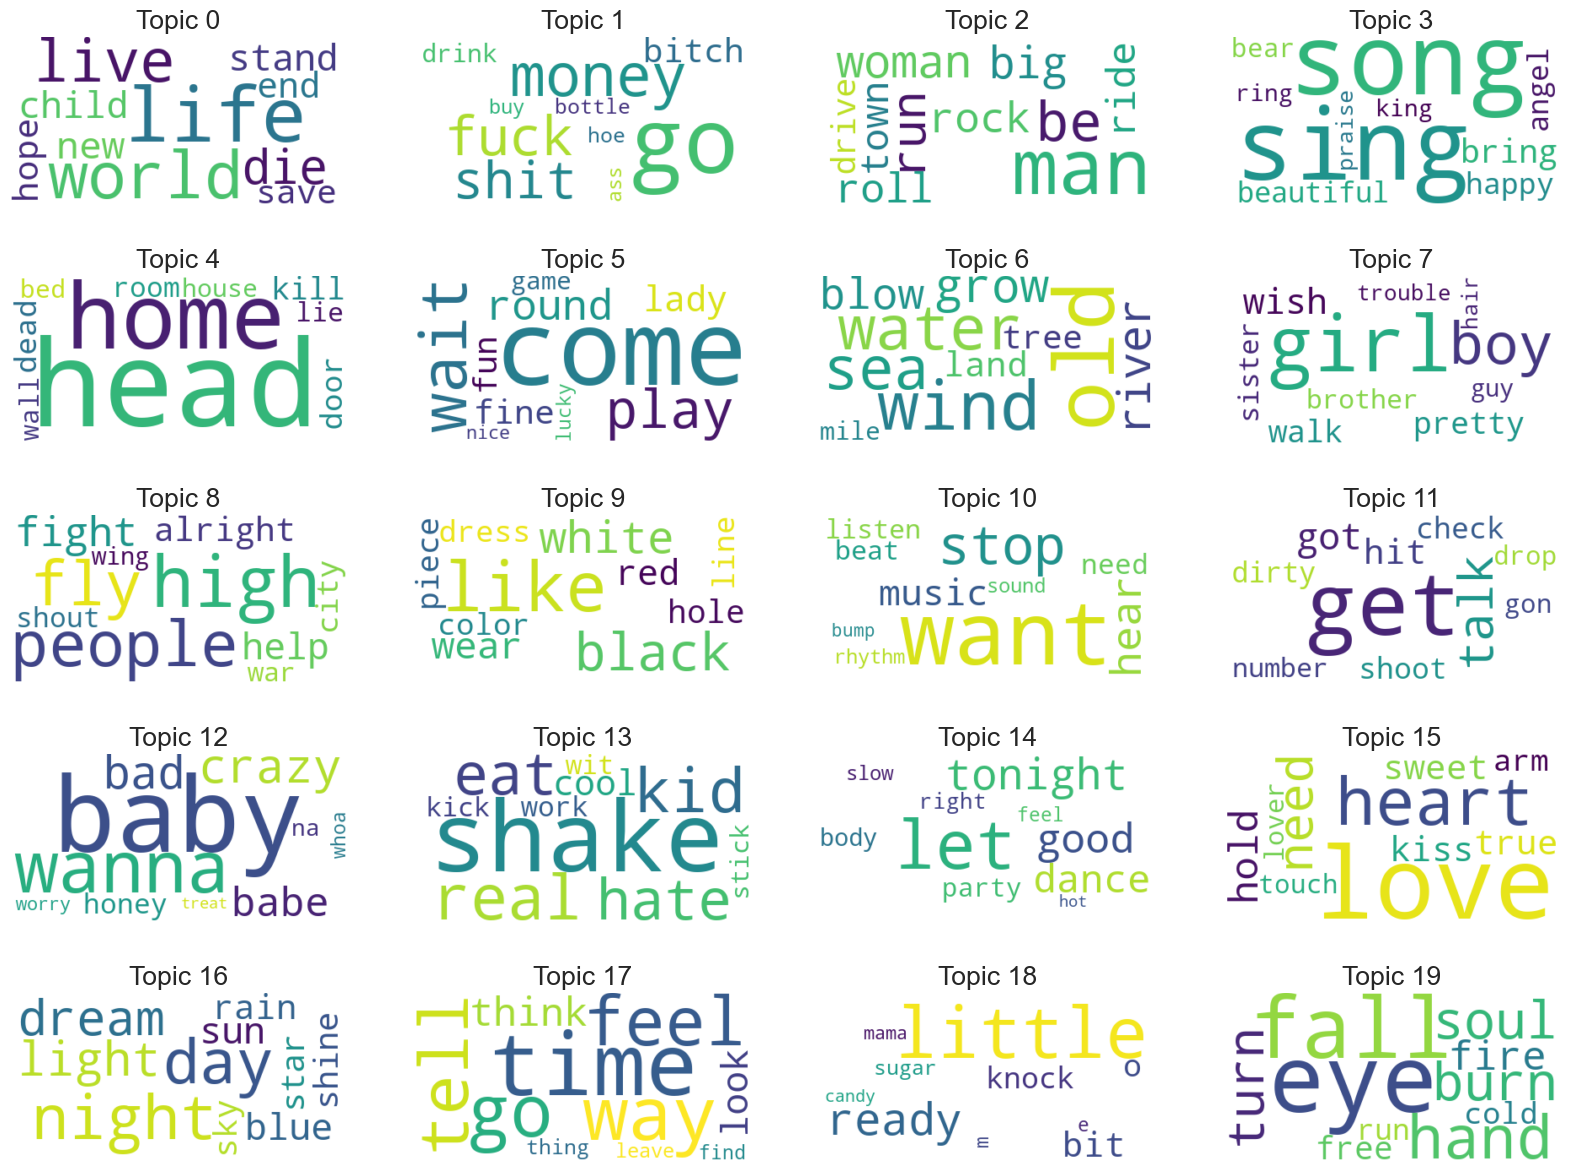

In [16]:
# Plot word clouds for each topic
word_cloud = WordCloud(background_color='white', max_words=10)
fig, axes = plt.subplots(5, 4, figsize=(20,15))

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(lda_model.show_topic(i))
    word_cloud.generate_from_frequencies(topic_words)
    plt.gca().imshow(word_cloud, interpolation='bilinear')
    plt.gca().set_title(f'Topic {i}')
    plt.gca().axis('off')
plt.show()

In [17]:
# Compute topic probabilities for each document
results = []
for i, doc in enumerate(bow):
    topic_probs = lda_model[doc]  # List of (topic_id, probability)
    for topic_id, prob in topic_probs:
        results.append({
            "song": songs_df.iloc[i]["song"],
            "topic": topic_id,
            "topic_probability": prob
        })

# Convert results to a DataFrame
topic_df = pd.DataFrame(results)

# Get top 10 contributors for each topic
top_contributors = (
    topic_df.sort_values(by=["topic", "topic_probability"], ascending=[True, False])
    .groupby("topic")
    .head(10)  # Get top 10 for each topic
    .reset_index(drop=True)
)

# Pivot table for a clear overview
summary_table = top_contributors.groupby("topic")["song"].apply(list).reset_index()
summary_table.columns = ["Topic", "Top Contributors"]

In [18]:
# Top Songs for Each Topic
summary_table.head()

,Topic,Top Contributors
0,0,"[Brave New World, Alive, Modern Girl, Justified, Jesus Is Alive [Live], God Is Able, Follow Your Lead, Beginning Of Sorrow, I Pledge Allegiance To The Lamb, Jah Live]"
1,1,"[Pop Muzik, Barbara Ann, Barabara Ann, Talkin' 'Bout You, Double, My Generation, Little Janey's Gone, Bitch Better Have My Money, My Generation, Y'all Want A Single]"
2,2,"[Car Crazy Cutie, Brother Trucker, Big Dog, Daddy, Daddy, Daddy, Cleveland Rocks, Fortunate Son, Get Your Rocks Off, Fortunate Son, Big Boss Man, Frank And Jesse James]"
3,3,"[Holy, Holy, Holy, Sing Along, Lord, I Worship You, Bells Of Christmas, And The Bells Rang, Happy Birthday, Hark! The Herald Angels Sing, I'm Singing, Caroling, Caroling, How Great Our Joy]"
4,4,"[In Heaven, Furry Walls, U Got Me Bugged, Sliver, I'll Be Mellow When I'm Dead, Afternoon Tea, Panic, Pessi-Mystic, Ghost Says Boo!, The Lonely Goatherd]"


Similar Documents

In [19]:
# Compute and rank consine similarities
lda_index = similarities.MatrixSimilarity(lda_model[bow], num_features=len(dct))

In [20]:
# Returns most similar songs to a given song
def get_similar_songs(song_bow, top_n=5, first_m_words=300):
    similar_songs = lda_index[lda_model[song_bow]]
    top_n_docs = sorted(enumerate(similar_songs), key=lambda item: -item[1])[1:top_n+1]
  
    # Returns (song id, similarity score, first_m_words of song)
    return list(map(lambda entry: (entry[0], entry[1], clean_data[entry[0]][:first_m_words]), top_n_docs))

In [21]:
# Example
print(data[6864][:300],'\n')
get_similar_songs(bow[6864])

[Verse:]  
She's just a girl and she's on fire  
Hotter than a fantasy, lonely like a highway  
She's living in a world and it's on fire  
Filled with catastrophe, but she knows she can fly away  
  
Ohhhh oh oh oh oh  
She got both feet on the ground  
And she's burning it down  
Ohhhh oh  



[(55449,
  0.9675786,
  "On her television, on her momma's radio  She could paint a picture  More alive than all she ought to know  Her imagination running wild, she let it grow  In her imagination  Oh she found she loved him so    [Chorus]  The eyes of the girl are following me  Looking for the man that she pinned on me  T"),
 (57163,
  0.9656957,
  "Lying soaked in sweat tonight,  Your knuckles white,  you try to fight,  The need for more to get you by,  You've had enough,  You wonder why,  Even now your body cries,  For chemicals to blind your eyes,  Wonder can you stay this high,  When the cells begin to die  Forever, Forever, Forever,    Cru"),
 (4134,
  0.96271247,
  "Sister of night  When the hunger descends  And your body's a fire  An inferno that never ends  An eternal flame  That burns in desire's name  Sister of night  When the longing returns  Giving voice to the flame  Calling you through flesh that burns  Breaking down your will  To move in for the kill  "),
 (11376,
  0.

In [22]:
#Songs not in corpus
# Pass new song through pipeline
new_song = "Demons on my shoulder Monsters in my head Shadow in the water Will you be my friend The world revolves around me As I lay in my bed Dreaming of more, more"
new_tokens = list(map(custom_tokenizer, [nlp(new_song)]))[0]
new_bow = dct.doc2bow(new_tokens)

print(new_song,'\n')
get_similar_songs(new_bow)

Demons on my shoulder Monsters in my head Shadow in the water Will you be my friend The world revolves around me As I lay in my bed Dreaming of more, more 



[(29573,
  0.9759016,
  "We're the horniest boys  With the corniest ploys  Who take the easiest girls  To our sleaziest worlds    With our lecherous plans  In our treacherous hands  You'd be wasting your time  Saying no, it's a crime    All that we live for you'll regret  All you remember we'll forget    We are the dead of "),
 (53522,
  0.97320926,
  "Old habits die hard  Old habits like loving you  Like spending my days and nights  In missing you  Hours that were yours echo like empty rooms  Strange faces and your place can't keep away the gloom  Old habits die hard now that you're gone  Old habits die hard  Old habits like being true  Like coun"),
 (40089,
  0.97233653,
  "This is the house that love built  Memories of you, built in each wall  One tender seed still haunt my dreams  Thought I just heard your voice in the hall  The mirrors reflect all the heartache I feel  Smiling photographs, don't seem real    [Chorus: ]  Nothing's been moved, but everything's changed"),
 (51772,
  

In [23]:
from spotipy import Spotify
from spotipy.oauth2 import SpotifyClientCredentials


In [24]:
CLIENT_ID = "d01e5abcf5fd423598e72b869ffe3f5a"
CLIENT_SECRET = "4243c573da344f13b1c418c04addaa47"

In [25]:
sp = Spotify(auth_manager=SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET))

In [26]:
playlist_id = "1yDawcV25BRwf149OFGgia" #https://open.spotify.com/playlist/1yDawcV25BRwf149OFGgia

In [27]:
def analyze_playlist(creator, playlist_id):
    
    # Create empty dataframe
    playlist_features_list = ["artist","album","track_name",  "track_id","danceability","energy","key","loudness","mode", "speechiness","instrumentalness","liveness","valence","tempo", "duration_ms","time_signature"]
    
    playlist_df = pd.DataFrame(columns = playlist_features_list)
    
    # Loop through every track in the playlist, extract features and append the features to the playlist df
    
    playlist = sp.user_playlist_tracks(creator, playlist_id)["items"]
    for track in playlist:
        # Create empty dict
        playlist_features = {}
        # Get metadata
        playlist_features["artist"] = track["track"]["album"]["artists"][0]["name"]
        playlist_features["album"] = track["track"]["album"]["name"]
        playlist_features["track_name"] = track["track"]["name"]
        playlist_features["track_id"] = track["track"]["id"]
        
        # Get audio features
        audio_features = sp.audio_features(playlist_features["track_id"])[0]
        for feature in playlist_features_list[4:]:
            playlist_features[feature] = audio_features[feature]
        
        # Concat the dfs
        track_df = pd.DataFrame(playlist_features, index = [0])
        playlist_df = pd.concat([playlist_df, track_df], ignore_index = True)
        
    return playlist_df

In [28]:
table = analyze_playlist("ugoanyaegbunam", playlist_id)
table = table.round(2)
table.head(45)

C:\Users\maryp\AppData\Local\Temp\ipykernel_19996\1894724600.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  playlist_df = pd.concat([playlist_df, track_df], ignore_index = True)


,artist,album,track_name,track_id,danceability,energy,key,loudness,mode,speechiness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,The Marías,Submarine,No One Noticed,3siwsiaEoU4Kuuc9WKMUy5,0.70,0.34,7,-10.61,1,0.03,0.08,0.12,0.46,97.99,236907,4
1,Rihanna,Good Girl Gone Bad,Don't Stop The Music,1Jo0Zg7XlrA6z0mFTZVdkn,0.83,0.67,6,-5.58,0,0.06,0.00,0.05,0.55,122.67,267080,4
2,Gus Dapperton,Orca,Palms,4NC020Ni4UqpqhmIt0PByw,0.75,0.56,4,-8.34,0,0.03,0.09,0.13,0.84,117.97,240240,4
3,MAGIC!,Don't Kill the Magic,Rude,6RtPijgfPKROxEzTHNRiDp,0.77,0.76,1,-4.99,1,0.04,0.00,0.30,0.92,144.03,224840,4
4,Tory Lanez,Alone at Prom (Deluxe),Poison Ivy,2gdz7TlVOlDemmW2RoI3st,0.75,0.79,1,-6.26,1,0.20,0.00,0.10,0.75,106.08,187924,4
5,Ozzy Osbourne,No More Tears (Expanded Edition),Hellraiser,4nvYDy427VvA1TcEkdgZII,0.40,0.85,4,-6.35,1,0.03,0.00,0.23,0.51,96.06,292720,4
6,Various Artists,Teen Beach Movie,"Cruisin' for a Bruisin' - From ""Teen Beach Movie""/Soundtrack Version",5e3UWcbvTaF5CJWu81MqlQ,0.58,0.91,11,-4.62,1,0.12,0.00,0.11,0.78,163.93,195733,4
7,Linkin Park,Hybrid Theory (Bonus Edition),In the End,60a0Rd6pjrkxjPbaKzXjfq,0.56,0.86,3,-5.87,0,0.06,0.00,0.21,0.40,105.14,216880,4
8,Natasha Bedingfield,Unwritten,Unwritten,3U5JVgI2x4rDyHGObzJfNf,0.71,0.80,5,-6.33,1,0.04,0.00,0.08,0.63,100.01,259333,4
9,Dave,Sprinter,Sprinter,2FDTHlrBguDzQkp7PVj16Q,0.92,0.68,1,-4.70,1,0.20,0.00,0.06,0.71,139.06,229133,4


In [29]:
def get_dominant_topic(lda_model, lyrics):
    # Get the topic distribution for the song
    topic_distribution = lda_model.get_document_topics(lda_model.id2word.doc2bow(lyrics.split()))  # Returns a list of tuples (topic_id, distribution)
    
    # If the topic_distribution is empty (e.g., no relevant topics), return None or a default topic
    if not topic_distribution:
        return None

    # Sort the topic distribution in descending order to get the topic with the highest distribution
    sorted_topics = sorted(topic_distribution, key=lambda x: x[1], reverse=True)

    # Return the topic number with the highest distribution
    return sorted_topics[0][0]  # Topic number is the first element of the tuple (topic_id)


In [30]:
def get_track_id(song_name, artist_name):
    # Create a search query using song name and artist
    query = f"track:{song_name} artist:{artist_name}"
    
    # Search for the track
    results = sp.search(q=query, type='track', limit=1)
    
    # Check if results are returned
    if results['tracks']['items']:
        # Get the first result (most relevant)
        track = results['tracks']['items'][0]
        track_id = track['id']
        return track_id
    else:
        # No results found
        return None

In [31]:
import time
from spotipy import SpotifyException
def get_song_features(song_name, artist_name, retries=5, backoff_factor=1.5):
    track_id = get_track_id(song_name, artist_name)
    
    if not track_id:
        features = {
        'danceability': np.nan, 
        'energy': np.nan, 
        'key': np.nan, 
        'loudness': np.nan, 
        'mode': np.nan, 
        'speechiness': np.nan, 
        'instrumentalness': np.nan, 
        'liveness': np.nan, 
        'valence': np.nan, 
        'tempo': np.nan
        }
        return features
    
    for attempt in range(retries):
        try:
            features = sp.audio_features([track_id])[0]
            return features
        except SpotifyException as e:
            if e.http_status == 429:  # Rate limit error
                wait_time = backoff_factor ** attempt + random.uniform(0, 1)  # Exponential backoff with random jitter
                print(f"Rate limit hit, retrying in {wait_time:.2f} seconds...")
                time.sleep(wait_time)
            else:
                raise  # Re-raise if it's not a rate limit error
    
    raise Exception(f"Max retries reached for fetching audio features for {song_name} by {artist_name}")

In [32]:
def get_avg_topic_features(songs_df):   
    danceability_vals = []
    energy_vals = []
    key_vals = []
    loudness_vals = []
    mode_vals = []
    speechiness_vals = []
    instrumentalness_vals = []
    liveness_vals = []
    valence_vals = []
    tempo_vals = []
    dominant_topics = []

    for index, row in songs_df.iterrows():
        song_name = row['song']  
        artist = row['artist']  
        lyrics = row['text']      

        features = get_song_features(song_name, artist)
        dominant_topic = get_dominant_topic(lda_model, lyrics)

        danceability_vals.append(features['danceability'])
        energy_vals.append(features['energy'])
        key_vals.append(features['key'])
        loudness_vals.append(features['loudness'])
        mode_vals.append(features['mode'])
        speechiness_vals.append(features['speechiness'])
        instrumentalness_vals.append(features['instrumentalness'])
        liveness_vals.append(features['liveness'])
        valence_vals.append(features['valence'])
        tempo_vals.append(features['tempo'])
        dominant_topics.append(dominant_topic)
    
    songs_df['danceability'] = danceability_vals
    songs_df['energy'] = energy_vals
    songs_df['key'] = key_vals
    songs_df['loudness'] = loudness_vals
    songs_df['mode'] = mode_vals
    songs_df['speechiness'] = speechiness_vals
    songs_df['instrumentalness'] = instrumentalness_vals
    songs_df['liveness'] = liveness_vals
    songs_df['valence'] = valence_vals
    songs_df['tempo'] = tempo_vals
    songs_df['dominant_topic'] = dominant_topics

    # Group by 'topic' and calculate statistics
    grouped_df = songs_df.groupby('dominant_topic').agg({
        'danceability': 'mean',  
        'energy': 'mean',        
        'key': 'mean',
        'loudness': 'mean',
        'mode': 'mean',
        'speechiness': 'mean',
        'instrumentalness': 'mean',
        'liveness' : 'mean',
        'valence' : 'mean',
        'tempo' : 'mean'
    }).reset_index()

    # Rename columns for clarity
    grouped_df.rename(columns={
    'dominant_topic': 'topic',
    'danceability': 'avg_danceability',
    'energy': 'avg_energy',
    'key': 'most_common_key',
    'loudness': 'avg_loudness',
    'mode': 'avg_mode',
    'speechiness': 'avg_speechiness',
    'instrumentalness': 'avg_instrumentalness',
    'liveness': 'avg_liveliness',
    'valence': 'avg_valence',
    'tempo': 'avg_tempo'
    }, inplace=True)

    return grouped_df



In [33]:
#would be really cool, but api only allows 300 requests an hour
contributors = summary_table['Top Contributors'].explode().unique()  
filtered_songs_df = songs_df[songs_df['song'].isin(contributors)]
topic_avgs = get_avg_topic_features(filtered_songs_df)

C:\Users\maryp\AppData\Local\Temp\ipykernel_19996\3921437946.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  songs_df['danceability'] = danceability_vals
C:\Users\maryp\AppData\Local\Temp\ipykernel_19996\3921437946.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  songs_df['energy'] = energy_vals
C:\Users\maryp\AppData\Local\Temp\ipykernel_19996\3921437946.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

In [34]:
topic_avgs = topic_avgs.round(2)
topic_avgs.head(20)

,topic,avg_danceability,avg_energy,most_common_key,avg_loudness,avg_mode,avg_speechiness,avg_instrumentalness,avg_liveliness,avg_valence,avg_tempo
0,0,0.48,0.71,5.18,-7.93,0.86,0.06,0.13,0.35,0.45,130.01
1,1,0.59,0.78,8.00,-5.26,0.25,0.09,0.20,0.18,0.68,105.09
2,2,0.57,0.70,4.47,-9.40,0.80,0.09,0.11,0.21,0.67,123.40
3,3,0.56,0.46,3.00,-11.88,0.92,0.09,0.00,0.22,0.50,114.96
4,4,0.57,0.56,4.62,-9.97,0.94,0.05,0.14,0.28,0.52,111.00
5,5,0.59,0.55,4.00,-9.72,0.93,0.06,0.01,0.30,0.50,106.10
6,6,0.49,0.49,4.90,-10.02,1.00,0.04,0.16,0.24,0.47,111.55
7,7,0.49,0.68,6.50,-8.83,0.83,0.05,0.09,0.30,0.53,134.15
8,8,0.52,0.67,5.73,-10.02,0.82,0.05,0.04,0.20,0.61,132.02
9,9,0.44,0.63,6.67,-9.93,1.00,0.06,0.03,0.17,0.46,135.29


In [35]:
def process_new_song(song, lyrics, lda_model, dictionary):
    # Preprocess the text (tokenize and convert to bag-of-words)
    bow = dictionary.doc2bow(lyrics.lower().split())
    
    # Get topic probabilities
    topic_probs = lda_model.get_document_topics(bow)
    
    # Find the dominant topic
    dominant_topic, topic_prob = max(topic_probs, key=lambda x: x[1])
    
    # Return result as a dictionary
    return {"name": song, "dominant_topic": dominant_topic, "topic_probability": topic_prob}

In [36]:
new_songs_to_lyrics = pd.read_csv('test_songs_lyrics - Sheet1.csv')

In [37]:
song_to_gpt_topic = { "No One Noticed": "Topic 1", "Don't Stop The Music": "Topic 9", "Palms": "Topic 18", "Rude": "Topic 10", "Poison Ivy": "Topic 6", "Hellraiser": "Topic 6", "Cruisin' for a Bruisin": "Topic 9", "In the End": "Topic 0", "Unwritten": "Topic 0", "Sprinter": "Topic 7", "Crooked Smile": "Topic 7", "Get You": "Topic 8", "Ode To The Mets": "Topic 2", "Workin Out": "Topic 0", "E. Coli": "Topic 6", "Snooze": "Topic 8", "Survive (Ban Rap)": "Topic 6", "Broken Vessels (Amazing Grace)": "Topic 0", "Last Time I Saw You": "Topic 1", "Motivation": "Topic 1", "Centuries": "Topic 5", "Courtesy Call": "Topic 6", "Best Mistake": "Topic 8", "Home": "Topic 10", "Send My Love (To Your New Lover)": "Topic 8", "Legends Never Die": "Topic 5", "How To Love": "Topic 8", "Boo'd Up": "Topic 8", "Adore You": "Topic 8", "Hold On": "Topic 0", "Mary On A Cross": "Topic 7", "Them Changes": "Topic 8", "The Color Violet": "Topic 8", "Rockstar": "Topic 6", "Fishin' in the Dark": "Topic 5", "3 Nights": "Topic 10", "End of Beginning": "Topic 0", "Hotel California": "Topic 7", "Southern Nights": "Topic 10", "Birds of a Feather": "Topic 4", "Play That Funky Music": "Topic 9", "Smooth Operator": "Topic 9", "Higher": "Topic 0", "Lost": "Topic 1", "Somewhere Over The Rainbow/What A Wonderful World": "Topic 4" }
our_topic_assignments = dict(zip(song_to_gpt_topic.keys(),[2,9,10,8,3,9,5,13,0,19,3,8,17,13,0,8,13,17,13,15,1,16,8,10,8,12,8,9,3,18,10,13,13,19,4,14,18,8,4,17,9,7,0,3,0 ]))
model_to_topic = {}
for song in song_to_gpt_topic.keys():
    df = new_songs_to_lyrics
    lyrics = df.loc[df['song'] == song, 'lyrics'].iloc[0]
    results = process_new_song(song, lyrics, lda_model, dct)
    model_to_topic[song] = results

songs_ordered = list(our_topic_assignments.keys())  # Assuming this is the correct order

# Create a dataframe keeping the song order intact
df = pd.DataFrame({
    'song_name': songs_ordered,
    'our_placement': ['Topic ' + str(our_topic_assignments[song]) for song in songs_ordered],
    'chatgpt_placement': [str(song_to_gpt_topic.get(song, '')) for song in songs_ordered],
    'model_dominant_topic': ['Topic ' + str(model_to_topic.get(song, {}).get('dominant_topic', '')) for song in songs_ordered],
    'topic_probability': [model_to_topic.get(song, {}).get('topic_probability', '') for song in songs_ordered]
})
print(our_topic_assignments)
print(song_to_gpt_topic)
print(model_to_topic)

{'No One Noticed': 2, "Don't Stop The Music": 9, 'Palms': 10, 'Rude': 8, 'Poison Ivy': 3, 'Hellraiser': 9, "Cruisin' for a Bruisin": 5, 'In the End': 13, 'Unwritten': 0, 'Sprinter': 19, 'Crooked Smile': 3, 'Get You': 8, 'Ode To The Mets': 17, 'Workin Out': 13, 'E. Coli': 0, 'Snooze': 8, 'Survive (Ban Rap)': 13, 'Broken Vessels (Amazing Grace)': 17, 'Last Time I Saw You': 13, 'Motivation': 15, 'Centuries': 1, 'Courtesy Call': 16, 'Best Mistake': 8, 'Home': 10, 'Send My Love (To Your New Lover)': 8, 'Legends Never Die': 12, 'How To Love': 8, "Boo'd Up": 9, 'Adore You': 3, 'Hold On': 18, 'Mary On A Cross': 10, 'Them Changes': 13, 'The Color Violet': 13, 'Rockstar': 19, "Fishin' in the Dark": 4, '3 Nights': 14, 'End of Beginning': 18, 'Hotel California': 8, 'Southern Nights': 4, 'Birds of a Feather': 17, 'Play That Funky Music': 9, 'Smooth Operator': 7, 'Higher': 0, 'Lost': 3, 'Somewhere Over The Rainbow/What A Wonderful World': 0}
{'No One Noticed': 'Topic 1', "Don't Stop The Music": 'Top

In [38]:
df = df.round(2)
df.head(45)

,song_name,our_placement,chatgpt_placement,model_dominant_topic,topic_probability
0,No One Noticed,Topic 2,Topic 1,Topic 17,0.36
1,Don't Stop The Music,Topic 9,Topic 9,Topic 17,0.29
2,Palms,Topic 10,Topic 18,Topic 0,0.21
3,Rude,Topic 8,Topic 10,Topic 2,0.28
4,Poison Ivy,Topic 3,Topic 6,Topic 19,0.29
5,Hellraiser,Topic 9,Topic 6,Topic 19,0.23
6,Cruisin' for a Bruisin,Topic 5,Topic 9,Topic 2,0.18
7,In the End,Topic 13,Topic 0,Topic 17,0.48
8,Unwritten,Topic 0,Topic 0,Topic 0,0.27
9,Sprinter,Topic 19,Topic 7,Topic 13,0.18


In [39]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(bow))  # a measure of how good the model is. lower the better.

# Coherence score (closer to 0 the better)
coherence_model_Umass = models.coherencemodel.CoherenceModel(model=lda_model, texts=tokenized_data, dictionary=dct, coherence='u_mass')
coherence_score = coherence_model_Umass.get_coherence()
print(f'UMass Coherence Score: {coherence_score:.4f}')


Perplexity:  -7.56090767963109
UMass Coherence Score: -3.3913


In [40]:
coherence_model_Uci = models.coherencemodel.CoherenceModel(model=lda_model, texts=tokenized_data, dictionary=dct, coherence='c_uci')
coherence_score = coherence_model_Uci.get_coherence()
print(f'Ucis Coherence Score: {coherence_score:.4f}')

Ucis Coherence Score: -0.2907


In [ ]:
import numpy as np
from scipy.spatial.distance import jensenshannon

def calculate_topic_consistency(lda_model, corpus, top_n=20):
    """
    Calculate topic consistency using Jensen-Shannon distance with handling for invalid values
    """
    # Get topic distributions for all documents
    doc_topics = [lda_model.get_document_topics(doc) for doc in corpus]
    
    # Convert to dense vectors and ensure proper normalization
    doc_topic_dist = []
    for doc in doc_topics:
        # Sort by topic ID and get only probabilities
        probs = [prob for _, prob in sorted(doc)]
        # Ensure normalization
        probs = np.array(probs)
        if np.sum(probs) > 0:  # Avoid division by zero
            probs = probs / np.sum(probs)
        doc_topic_dist.append(probs)
    
    # Calculate pairwise distances
    valid_distances = []
    for i in range(len(doc_topic_dist)):
        for j in range(i+1, len(doc_topic_dist)):
            dist = jensenshannon(doc_topic_dist[i], doc_topic_dist[j])
            # Only include valid (non-nan) distances
            if not np.isnan(dist):
                valid_distances.append(dist)
    
    # Average distance (lower = more consistent)
    # Only calculate if we have valid distances
    if valid_distances:
        consistency = 1 - np.mean(valid_distances)
    else:
        consistency = 0  # or another default value
    print('Consistency = ', consistency)
    return consistency

# Usage
consistency_score = calculate_topic_consistency(lda_model, corpus=bow)

C:\Users\maryp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\spatial\distance.py:1271: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)


In [ ]:
def calculate_topic_diversity(lda_model=bow, top_n=20):
    """
    Calculate topic diversity - ratio of unique words across all topics
    
    Parameters:
    - lda_model: trained Gensim LDA model
    - top_n: number of top words per topic to consider
    
    Returns:
    - diversity score between 0 and 1 (higher = more diverse)
    """
    # Get top words for each topic
    topics = [dict(lda_model.show_topic(topic_id, topn=top_n)) 
             for topic_id in range(lda_model.num_topics)]
    
    # Get unique words across all topics
    unique_words = set(word for topic in topics 
                      for word, _ in topic.items())
    
    # Calculate diversity: unique words / (top_n * num_topics)
    diversity = len(unique_words) / (top_n * lda_model.num_topics)
    print('Diversity: ', diversity)
    return diversity

# Usage
diversity_score = calculate_topic_diversity(lda_model=lda_model, top_n=20)

In [ ]:
import numpy as np
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import gensim.downloader as api

# Choose ONE of these methods (not both):
# Method 1: Using gensim downloader
word2vec_model = api.load('word2vec-google-news-300')

# DELETE or comment out this part since we're using the downloader above
# word2vec_model = KeyedVectors.load_word2vec_format(
#     'GoogleNews-vectors-negative300.bin', 
#     binary=True
# )

def calculate_topic_interpretability(lda_model, word2vec_model, top_n=10):
    """
    Calculate topic interpretability using word embeddings
    
    Parameters:
    - lda_model: trained LDA model
    - word2vec_model: trained Word2Vec model
    - top_n: number of top words per topic
    """
    interpretability_scores = []
    
    # For each topic
    for topic_id in range(lda_model.num_topics):
        # Get top words
        top_words = [word for word, _ in lda_model.show_topic(topic_id, topn=top_n)]
        
        # Calculate average similarity between word pairs
        similarities = []
        for i in range(len(top_words)):
            for j in range(i + 1, len(top_words)):
                word1, word2 = top_words[i], top_words[j]
                try:
                    similarity = word2vec_model.similarity(word1, word2)
                    similarities.append(similarity)
                except KeyError:
                    continue
                    
        # Average similarity for this topic
        topic_interpretability = np.mean(similarities) if similarities else 0
        interpretability_scores.append(topic_interpretability)
    
    print('Interpretability scores: ', interpretability_scores, np.mean(interpretability_scores))
    return np.mean(interpretability_scores), interpretability_scores

# Usage
avg_interpretability, topic_scores = calculate_topic_interpretability(
    lda_model=lda_model,
    word2vec_model=word2vec_model
)